# Regresion Basica: Predecir eficiencia de gasolina

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir el consumo de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

El objetivo de este ejercicio es predecir el target miles per galon (MPG), que vendría a representar las millas por galón de combustible.

Este ejemplo usa el API `tf.keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [52]:
import pathlib

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


## El set de Datos de MPG

El set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Obtenga los datos
Primero descargue el set de datos.

In [53]:
dataset_path = keras.utils.get_file("auto-mpg.data",
                                    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\pilar\\.keras\\datasets\\auto-mpg.data'

Importelo usando pandas.

In [54]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Limpia los datos

Trata los missings y variables categóricas

In [55]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [56]:
dataset.shape

(398, 8)

In [57]:
dataset.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [58]:
dataset.isnull().sum()['Horsepower']/dataset.shape[0]

0.01507537688442211

In [59]:
dataset[dataset['Horsepower'].isnull()]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
32,25.0,4,98.0,NaN,2046.0,19.0,71,1
126,21.0,6,200.0,NaN,2875.0,17.0,74,1
330,40.9,4,85.0,NaN,1835.0,17.3,80,2
336,23.6,4,140.0,NaN,2905.0,14.3,80,1
354,34.5,4,100.0,NaN,2320.0,15.8,81,2
374,23.0,4,151.0,NaN,3035.0,20.5,82,1


In [62]:
df = dataset.copy()
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [63]:
df.dropna(axis=0, inplace=True)

In [64]:
df.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [65]:
df.shape

(392, 8)

In [66]:
#Cylinders
df['Cylinders'].unique()

array([8, 4, 6, 3, 5], dtype=int64)

In [67]:
df['Model Year'].unique()

array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82], dtype=int64)

In [68]:
df['Origin'].unique()

array([1, 3, 2], dtype=int64)

In [69]:
df.Displacement.unique()

array([307. , 350. , 318. , 304. , 302. , 429. , 454. , 440. , 455. ,
       390. , 383. , 340. , 400. , 113. , 198. , 199. , 200. ,  97. ,
       110. , 107. , 104. , 121. , 360. , 140. , 232. , 225. , 250. ,
       351. , 258. , 122. , 116. ,  79. ,  88. ,  71. ,  72. ,  91. ,
        97.5,  70. , 120. ,  96. ,  98. , 108. , 155. ,  68. , 114. ,
       156. ,  76. ,  83. ,  90. , 231. , 262. , 134. , 119. , 171. ,
       115. , 101. , 305. ,  85. , 130. , 168. , 111. , 260. , 151. ,
       146. ,  80. ,  78. , 105. , 131. , 163. ,  89. , 267. ,  86. ,
       183. , 141. , 173. , 135. ,  81. , 145. , 112. , 181. , 144. ])

In [17]:
#df = pd.get_dummies(data= df, columns=['Model Year'], drop_first=True)

In [18]:
#df = pd.get_dummies(data= df, columns=['Cylinders'], drop_first=True)

In [70]:
df = pd.get_dummies(data= df, columns=['Origin'])

In [71]:
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0


### Divide los datos en train y test

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas. 80% para entrenamiento

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

NOTA: El resultado tienen que ser dos datasets

In [72]:
X = df.drop(columns='MPG')
y = df['MPG']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size= 0.20, random_state= 42)

In [73]:
print("X_train_full_shape:", X_train_full.shape)
print("y_train_full_shape:", y_train_full.shape)

X_train_full_shape: (313, 9)
y_train_full_shape: (313,)


In [74]:
print("X_test_shape:", X_test.shape)
print("y_test_shape:", y_test.shape)

X_test_shape: (79, 9)
y_test_shape: (79,)


### Inspecciona los datos

Revise rapidamente la distribucion conjunta del dataset de entrenamiento mediante un grid de gráficos

In [77]:
df.columns

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'Origin_1', 'Origin_2', 'Origin_3'],
      dtype='object')

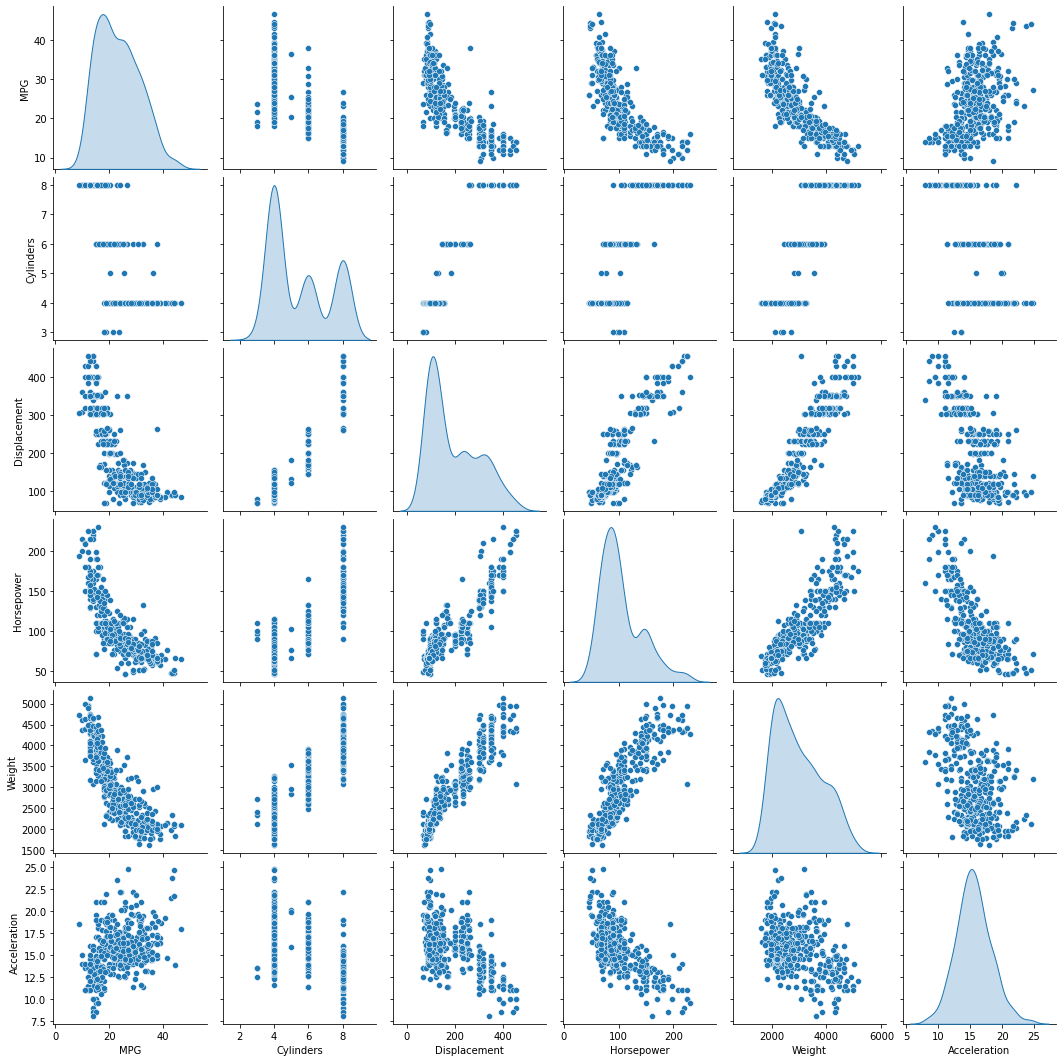

In [78]:
sns.pairplot(data=df[['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration']], diag_kind='kde')

Tambien revise las estadisticas generales:

In [79]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MPG,392.0,23.445918,7.805007,9.0,17.000,22.75,29.000,46.6
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.00,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.00,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.50,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.50,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.50,17.025,24.8
Model Year,392.0,75.979592,3.683737,70.0,73.000,76.00,79.000,82.0
Origin_1,392.0,0.625000,0.484742,0.0,0.000,1.00,1.000,1.0
Origin_2,392.0,0.173469,0.379136,0.0,0.000,0.00,0.000,1.0
Origin_3,392.0,0.201531,0.401656,0.0,0.000,0.00,0.000,1.0


### Separa las features del target

Separe el target de las features.

In [80]:
X_train_full.shape, X_test.shape

((313, 9), (79, 9))

In [81]:
y_train_full.shape, y_test.shape

((313,), (79,))

### Estandariza los datos

Es una buena práctica estandarizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo podría converger sin estandarizar, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

In [82]:
scaler = StandardScaler()
scaler.fit(X_train_full)
X_train_full_std = scaler.transform(X_train_full)
X_test_std = scaler.transform(X_test)

Estos datos estandarizados es lo que usaremos para entrenar el modelo.

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

Por tanto, tendrá tres capas. Una de entrada con activación relu. Otra hidden layer con activación relu y la de salida de regresión, que se compondrá de una única neurona. Pon las neuronas que consideres para las dos primeras capas.

Para el compile utiliza un loss='mse'.

optimizer = `tf.keras.optimizers.RMSprop(0.001)`

Y en metrics añade en una lista el `mae` y `mse`.

In [83]:
X_train_full_std.shape[1:]

(9,)

In [93]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(units=100,
                             input_shape= X_train_full_std.shape[1:] , #El parametro necesita una tupla ==> 1D
                             activation='relu'))

model.add(keras.layers.Dense(units=50,
                             activation= 'relu'))

model.add(keras.layers.Dense(units=1,
                             activation= 'relu'))


In [94]:
"""
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss= [tf.keras.losses.mean_squared_error, tf.keras.losses.mean_squared_error],
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanSquaredError()])
              """

'\nmodel.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),\n              loss= [tf.keras.losses.mean_squared_error, tf.keras.losses.mean_squared_error],\n              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanSquaredError()])\n              '

In [95]:
model.compile(loss="mean_squared_error",
            optimizer = tf.keras.optimizers.RMSprop(0.001),
            metrics=['mae','mse'])

### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [96]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               1000      
_________________________________________________________________
dense_10 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 6,101
Trainable params: 6,101
Non-trainable params: 0
_________________________________________________________________


### Entrenar el modelo

Entrene el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

NOTA: recuerda usar los datos normalizados.

In [ ]:
"""
X_train, X_val, y_train, y_val = train_test_split(X_train_full_std, y_train_full, test_size= 0.20, random_state= 42)


In [89]:
# X_val.shape

In [ ]:
"""
history = model.fit(X_train, y_train,
                    epochs=1000,
                    validation_data= (X_val, y_val)
                    )
"""

In [98]:
history = model.fit(X_train_full_std, y_train_full,
                    epochs=1000,
                    validation_split=0.20
                    )

val_mae: 2.0793 - val_mse: 8.0803
Epoch 880/1000
8/8 [==============================] - 0s 11ms/step - loss: 2.1040 - mae: 0.9165 - mse: 2.1040 - val_loss: 7.0077 - val_mae: 1.9180 - val_mse: 7.0077
Epoch 881/1000
8/8 [==============================] - 0s 11ms/step - loss: 3.3669 - mae: 1.1251 - mse: 3.3669 - val_loss: 6.5252 - val_mae: 1.8331 - val_mse: 6.5252
Epoch 882/1000
8/8 [==============================] - 0s 11ms/step - loss: 3.7079 - mae: 1.1789 - mse: 3.7079 - val_loss: 7.9419 - val_mae: 2.0577 - val_mse: 7.9419
Epoch 883/1000
8/8 [==============================] - 0s 10ms/step - loss: 2.7962 - mae: 1.0666 - mse: 2.7962 - val_loss: 6.1559 - val_mae: 1.8019 - val_mse: 6.1559
Epoch 884/1000
8/8 [==============================] - 0s 14ms/step - loss: 3.5835 - mae: 1.3018 - mse: 3.5835 - val_loss: 6.7092 - val_mae: 1.8595 - val_mse: 6.7092
Epoch 885/1000
8/8 [==============================] - 0s 11ms/step - loss: 2.4561 - mae: 1.0532 - mse: 2.4561 - val_loss: 6.4761 - val_mae: 1

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [99]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
990,2.693303,1.053599,2.693303,7.003579,1.943441,7.003579,990
991,2.840758,1.049565,2.840758,8.291977,2.118878,8.291977,991
992,2.854290,1.049598,2.854290,8.229653,2.131047,8.229653,992
993,2.864271,1.038872,2.864271,6.662304,1.868308,6.662304,993
994,2.822249,1.078415,2.822249,6.395564,1.856570,6.395564,994
995,2.855640,1.102766,2.855640,6.721102,1.872364,6.721102,995
996,2.760621,1.072622,2.760621,8.339476,2.157895,8.339476,996
997,2.824903,1.064161,2.824903,7.508052,2.025542,7.508052,997
998,2.641922,1.034983,2.641922,7.258572,1.954451,7.258572,998
999,2.869159,1.071579,2.869159,6.501293,1.888698,6.501293,999


In [100]:
hist['mae'].min(), hist['mae'].max()

(1.0192594528198242, 22.196168899536133)

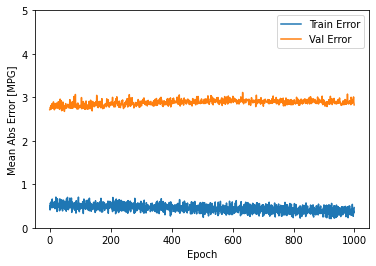

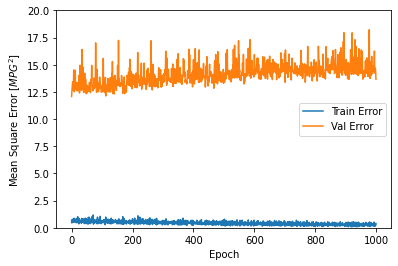

In [102]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

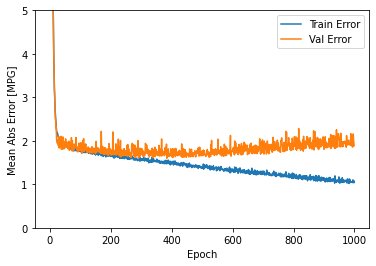

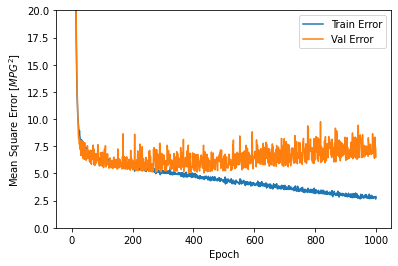

In [101]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

¿Alguna conclusión respecto a este gráfico?

In [ ]:
Que a medida que a medida que aumenta las 'epocas' el error aumenta también, y las perdida son mayores

Añade un early stopping al modelo. Pon el argumento `callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]` dentro del fit().

Después del entrenamiento utiliza la función del apartado anterior `plot_history(history)`.

In [103]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(units=100,
                             input_shape= X_train_full_std.shape[1:] , #El parametro necesita una tupla ==> 1D
                             activation='relu'))

model.add(keras.layers.Dense(units=50,
                             activation= 'relu'))

model.add(keras.layers.Dense(units=1,
                             activation= 'relu'))

model.compile(loss="mean_squared_error",
            optimizer = tf.keras.optimizers.RMSprop(0.001),
            metrics=['mae','mse'])

In [107]:
history = model (X_train_full_std, 
                    y_train_full,
                    epochs=1000,
                    validation_split=0.20,
                    verbose= 0,
                    callbacks= [keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)])

TypeError: call() got an unexpected keyword argument 'epochs'

Interpreta el gráfico

In [ ]:
plot_history(history)

Veamos qué tan bien generaliza el modelo al usar el conjunto de **test**. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real. Utiliza el método `evaluate` con los datos de test normalizados y sus labels.

Con el método evaluate devolverá tres valores: loss, mae y mse.

In [108]:
loss, mae, mse = model.evaluate(X_test_std, y_test, verbose=2)

3/3 - 0s - loss: 565.5725 - mae: 22.7102 - mse: 565.5725


In [109]:
print(f"Testing set MAE: {round(mae,2)} MPG")

Testing set MAE: 22.71 MPG


In [ ]:
example_batc

Ahora prueba el modelo. Coge 10 ejemplos de train y llama a` model.predict`.

In [110]:
example_batch = X_train_full_std[:10]
example_batch

array([[ 0.30486156,  0.28457757,  0.14142863,  0.75480297,  1.1217589 ,
         0.49452752,  0.74128601, -0.42559614, -0.50199602],
       [-0.87318372, -0.53588042, -0.32949862, -0.49312922, -0.22893966,
        -0.0572982 ,  0.74128601, -0.42559614, -0.50199602],
       [ 0.30486156, -0.23665456, -0.19868549, -0.00252992, -0.37111846,
        -0.33321105,  0.74128601, -0.42559614, -0.50199602],
       [ 1.48290683,  1.18225513,  1.18793363,  1.3680521 , -0.72656545,
        -1.16094962,  0.74128601, -0.42559614, -0.50199602],
       [-0.87318372, -1.05711255, -1.06205212, -1.32309939,  0.30423083,
         1.32226608,  0.74128601, -0.42559614, -0.50199602],
       [ 1.48290683,  1.97375578,  2.23443863,  1.59429934, -1.18864653,
         0.21861466,  0.74128601, -0.42559614, -0.50199602],
       [-0.87318372, -1.02815521, -1.11437737, -1.35882264, -0.08676086,
         1.04635323, -1.34900698,  2.34964536, -0.50199602],
       [ 0.30486156, -0.14013009,  0.14142863, -0.04897015,  0

In [114]:
example_result = model.predict(example_batch)
example_result

array([[0.14887656],
       [0.02394598],
       [0.00809071],
       [0.        ],
       [0.67500454],
       [0.        ],
       [0.06425424],
       [0.33002904],
       [0.1804101 ],
       [0.11500983]], dtype=float32)

### Haz Predicciones

Dibuja en un scatter plot las predicciones de test vs sus true labels.

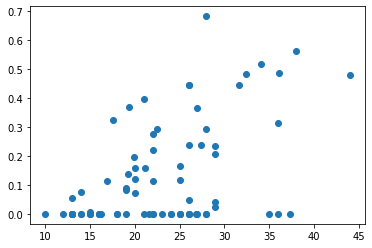

In [115]:
test_predictions = model.predict(X_test_std).flatten()

plt.scatter(y_test, test_predictions)

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

Representa los residuos en un histograma

(array([ 1.,  0.,  0.,  0.,  2.,  3.,  1.,  1.,  1.,  1.,  3.,  4.,  5.,
        12.,  2.,  2.,  8.,  5.,  5.,  4.,  4.,  4.,  9.,  1.,  1.]),
 array([-43.52005234, -42.17925025, -40.83844816, -39.49764606,
        -38.15684397, -36.81604187, -35.47523978, -34.13443769,
        -32.79363559, -31.4528335 , -30.11203141, -28.77122931,
        -27.43042722, -26.08962512, -24.74882303, -23.40802094,
        -22.06721884, -20.72641675, -19.38561466, -18.04481256,
        -16.70401047, -15.36320837, -14.02240628, -12.68160419,
        -11.34080209, -10.        ]),
 <BarContainer object of 25 artists>)

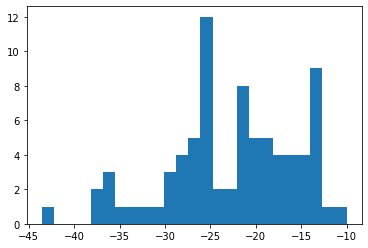

In [117]:
error = test_predictions - y_test

plt.hist(error, bins=25)


No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

## Conclusion

Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* La detención temprana es una técnica útil para evitar el sobreajuste.